## 8.1 컨볼루션

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [6]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
from torchvision import datasets, transforms

In [8]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ])
)

Files already downloaded and verified


In [9]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ])
)

Files already downloaded and verified


In [10]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

### 8.1.1 컨볼루션의 역할

## 8.2 컨볼루션 사용해보기

In [2]:
import torch
import torch.nn as nn

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

convolution weight shape : out_channel x input_channel x kernel_size

In [11]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

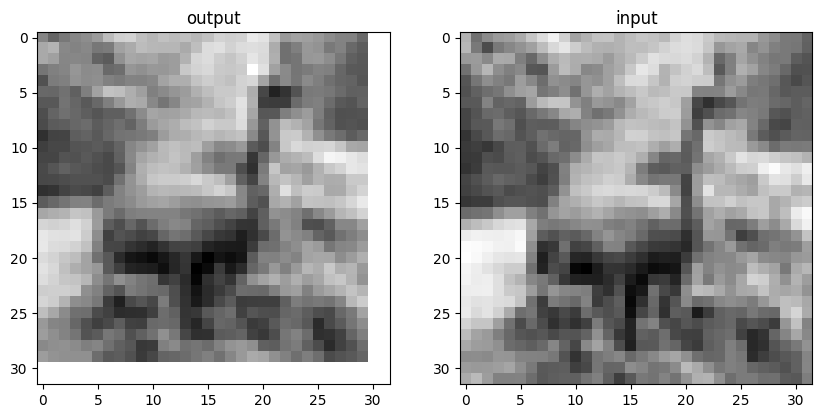

In [14]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

### 8.2.1 경계 패딩하기

In [15]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

### 8.2.2 컨볼루션으로 피처 찾아내기

In [16]:
with torch.no_grad():
    conv.bias.zero_()

In [17]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

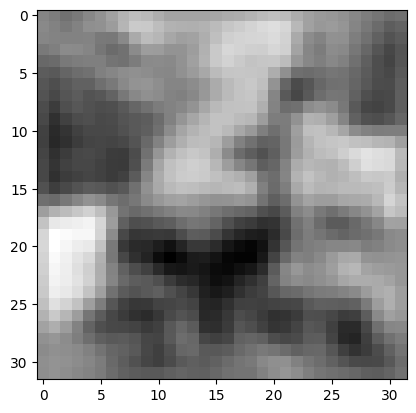

In [18]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

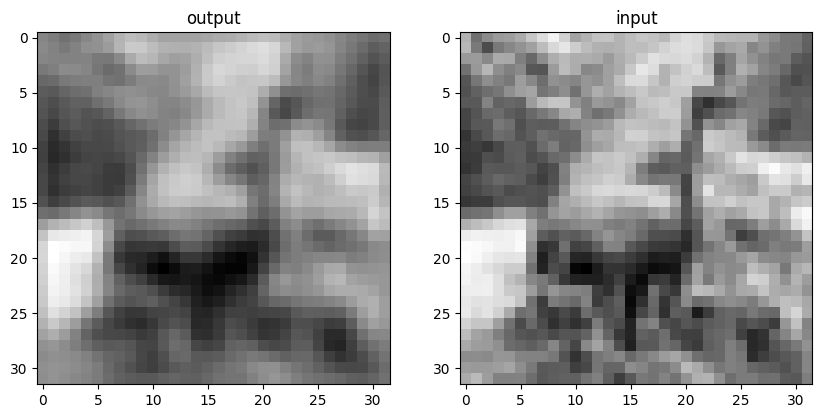

In [19]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [20]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0]])
    conv.bias.zero_()

수직 경계를 탐색하는 역할을 함

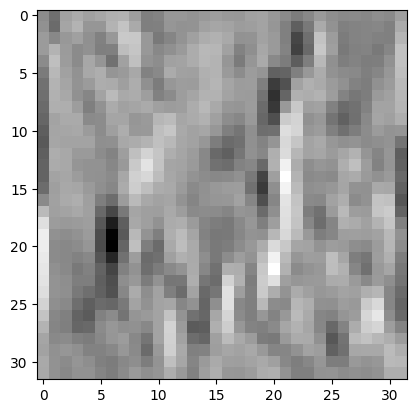

In [21]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

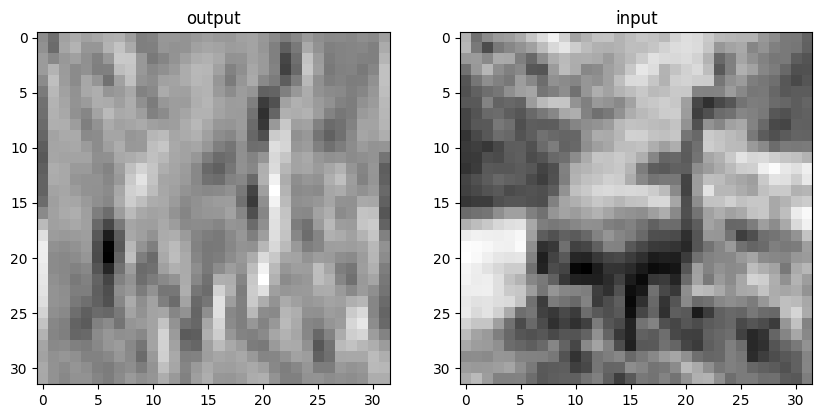

In [22]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

### 8.2.3 깊이와 풀링으로 한 단계 더 인식하기

#### 큰 이미지에서 작은 이미지로: 다운샘플링

In [23]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### 더 나은 성능을 위해 컨볼루션과 다운샘플링 결합하기

### 8.2.4 우리의 신경망에 적용하기

In [24]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...
)

In [25]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
)

In [26]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [29]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

## 8.3 nn.Module 서브클래싱하기

### 8.3.1 nn.Module 로 정의된 우리의 신경망

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

### 8.3.2 파이토치가 파라미터와 서브모듈을 유지하는 방법

In [32]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### 8.3.3 함수형 API

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [34]:
model = Net()

model(img.unsqueeze(0))

tensor([[-0.0265,  0.1108]], grad_fn=<AddmmBackward0>)

## 8.4 우리가 만든 컨볼루션 신경망 훈련시키기

In [35]:
import datetime

In [38]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [39]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2022-12-19 17:30:31.291264 Epoch 1, Training loss 0.5835789476230646
2022-12-19 17:30:38.100558 Epoch 10, Training loss 0.3410885232459208
2022-12-19 17:30:46.451971 Epoch 20, Training loss 0.29464452946261993
2022-12-19 17:30:54.737185 Epoch 30, Training loss 0.26854647240441315
2022-12-19 17:31:02.329437 Epoch 40, Training loss 0.24979834424652111
2022-12-19 17:31:10.709573 Epoch 50, Training loss 0.2320592247281864
2022-12-19 17:31:18.446588 Epoch 60, Training loss 0.22031663543289634
2022-12-19 17:31:25.997810 Epoch 70, Training loss 0.20380599744570482
2022-12-19 17:31:34.448049 Epoch 80, Training loss 0.18893716949376332
2022-12-19 17:31:41.987990 Epoch 90, Training loss 0.17891844257617454
2022-12-19 17:31:49.694282 Epoch 100, Training loss 0.16607845194969967


### 8.4.1 정확도 측정

In [40]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print('Accuracy {}: {:.2f}'.format(name, correct / total))
        
validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


### 8.4.2 모델을 저장하고 불러오기

In [41]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [42]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 8.4.3 GPU 에서 훈련시키기

In [44]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training on device {device}')

Training on device cuda


In [45]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [46]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2022-12-19 17:46:15.582215 Epoch 1, Training loss 0.5700976444277793
2022-12-19 17:46:17.561533 Epoch 10, Training loss 0.339445932940313
2022-12-19 17:46:19.647896 Epoch 20, Training loss 0.301586305259899
2022-12-19 17:46:21.753122 Epoch 30, Training loss 0.26953030681344353
2022-12-19 17:46:23.887774 Epoch 40, Training loss 0.24625162163357825
2022-12-19 17:46:26.052068 Epoch 50, Training loss 0.2273902804323822
2022-12-19 17:46:28.212396 Epoch 60, Training loss 0.20949122955085367
2022-12-19 17:46:30.337672 Epoch 70, Training loss 0.19286721261443607
2022-12-19 17:46:32.436438 Epoch 80, Training loss 0.17592360719943503
2022-12-19 17:46:34.556582 Epoch 90, Training loss 0.1636454655676131
2022-12-19 17:46:36.710031 Epoch 100, Training loss 0.14891791372162522


In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print('Accuracy {}: {:.2f}'.format(name, correct / total))
        accdict[name] = correct / total
    return accdict
        
all_acc_dict['baseline'] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


In [51]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9421, 'val': 0.8875})])

In [47]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

## 8.5 모델 설계

### 8.5.1 메모리 용량 늘리기: 너비

In [48]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [49]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chans1 // 2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, self.n_chans1 // 2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

validate(model, train_loader, val_loader)

2022-12-19 17:57:00.635838 Epoch 1, Training loss 0.5508495677428641
2022-12-19 17:57:02.649631 Epoch 10, Training loss 0.3225786498018131
2022-12-19 17:57:04.878282 Epoch 20, Training loss 0.2742170329876007
2022-12-19 17:57:07.124222 Epoch 30, Training loss 0.2398937265774247
2022-12-19 17:57:09.365413 Epoch 40, Training loss 0.20956511676880965
2022-12-19 17:57:11.591134 Epoch 50, Training loss 0.18297791756262446
2022-12-19 17:57:13.813343 Epoch 60, Training loss 0.15947045419056705
2022-12-19 17:57:16.083175 Epoch 70, Training loss 0.1376275511541564
2022-12-19 17:57:18.315485 Epoch 80, Training loss 0.11752992832831516
2022-12-19 17:57:20.517591 Epoch 90, Training loss 0.0993531509569496
2022-12-19 17:57:22.730892 Epoch 100, Training loss 0.08291368349010397
Accuracy train: 0.96
Accuracy val: 0.89


{'train': 0.9639, 'val': 0.891}

In [55]:
sum(p.numel() for p in model.parameters())

38386

### 8.5.2 모델이 수렴하고 일반화하도록 돕는 방법: 정규화

#### 파라미터 제어하기: 가중치 페널티

In [56]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # L1 정규화라면 pow(2.0)을 abs()로 바꾼다.
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

파이토치의 SGD 옵티마이저에는 이미 weight_decay 파라미터가 있고 2 * lambda 값을 가지며 업데이트 동작시 앞에서 설명한 것처럼 가중치 감쇠를 수행함

손실값에 가중치의 L2 정규화를 더한 것과 동일하므로, 자동미분과 손실값에서 항을 누적하는 작업을 할 필요가 없음

In [57]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

all_acc_dict['l2_reg'] = validate(model, train_loader, val_loader)

2022-12-19 18:07:24.687420 Epoch 1, Training loss 0.5835498231611435
2022-12-19 18:07:27.405389 Epoch 10, Training loss 0.3613172097570577
2022-12-19 18:07:30.417738 Epoch 20, Training loss 0.3218512478148102
2022-12-19 18:07:33.427970 Epoch 30, Training loss 0.3013272769511885
2022-12-19 18:07:36.440438 Epoch 40, Training loss 0.28436601693463176
2022-12-19 18:07:39.432655 Epoch 50, Training loss 0.2702702239250681
2022-12-19 18:07:42.498785 Epoch 60, Training loss 0.25788748463627637
2022-12-19 18:07:45.500617 Epoch 70, Training loss 0.24670489597472417
2022-12-19 18:07:48.509317 Epoch 80, Training loss 0.23636788234209558
2022-12-19 18:07:51.548949 Epoch 90, Training loss 0.22668245358831562
2022-12-19 18:07:54.561746 Epoch 100, Training loss 0.21727746359671757
Accuracy train: 0.92
Accuracy val: 0.88


In [58]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9421, 'val': 0.8875}),
             ('l2_reg', {'train': 0.9152, 'val': 0.879})])

#### 입력 하나에 너무 의존하지 않기: 드랍아웃

In [65]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [66]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

all_acc_dict['dropout'] = validate(model, train_loader, val_loader)

2022-12-19 18:15:02.324320 Epoch 1, Training loss 0.5842771197959875
2022-12-19 18:15:04.487523 Epoch 10, Training loss 0.3779874796130855
2022-12-19 18:15:06.868083 Epoch 20, Training loss 0.34632711245375836
2022-12-19 18:15:09.228575 Epoch 30, Training loss 0.3274622998040193
2022-12-19 18:15:11.624863 Epoch 40, Training loss 0.3161336722647309
2022-12-19 18:15:14.019735 Epoch 50, Training loss 0.30364657435447545
2022-12-19 18:15:16.392734 Epoch 60, Training loss 0.2867541668141723
2022-12-19 18:15:18.775142 Epoch 70, Training loss 0.27629693706703795
2022-12-19 18:15:21.169843 Epoch 80, Training loss 0.2624229128668263
2022-12-19 18:15:23.618928 Epoch 90, Training loss 0.25319358640036005
2022-12-19 18:15:26.014799 Epoch 100, Training loss 0.2486215654736871
Accuracy train: 0.90
Accuracy val: 0.87


In [67]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9421, 'val': 0.8875}),
             ('l2_reg', {'train': 0.9152, 'val': 0.879}),
             ('dropout', {'train': 0.8995, 'val': 0.8695})])

#### 활성 함수 억제하기: 배치 정규화

In [68]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

배치 정규화의 위치는 활성함수의 입력 조정이 목적이기 때문에 활성화함수 전에 입력

In [69]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

all_acc_dict['batch_norm'] = validate(model, train_loader, val_loader)

2022-12-19 18:23:50.078599 Epoch 1, Training loss 0.43517959269748374
2022-12-19 18:23:52.491180 Epoch 10, Training loss 0.26240215108842607
2022-12-19 18:23:55.151547 Epoch 20, Training loss 0.20137498992833364
2022-12-19 18:23:57.795361 Epoch 30, Training loss 0.15179970748959834
2022-12-19 18:24:00.424753 Epoch 40, Training loss 0.1106595093514889
2022-12-19 18:24:03.071790 Epoch 50, Training loss 0.07718801200627141
2022-12-19 18:24:05.768054 Epoch 60, Training loss 0.05295427064085083
2022-12-19 18:24:08.416555 Epoch 70, Training loss 0.040487401145895954
2022-12-19 18:24:11.079263 Epoch 80, Training loss 0.021847835940658856
2022-12-19 18:24:13.744859 Epoch 90, Training loss 0.02455334971320762
2022-12-19 18:24:16.441837 Epoch 100, Training loss 0.01023340805071839
Accuracy train: 0.98
Accuracy val: 0.87


In [70]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9421, 'val': 0.8875}),
             ('l2_reg', {'train': 0.9152, 'val': 0.879}),
             ('dropout', {'train': 0.8995, 'val': 0.8695}),
             ('batch_norm', {'train': 0.9831, 'val': 0.873})])

### 8.5.3 더 복잡한 구조를 배우기 위해 깊이 파헤치기: 깊이

#### 스킵 커넥션

In [73]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [74]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

all_acc_dict['depth'] = validate(model, train_loader, val_loader)

2022-12-19 18:34:09.491847 Epoch 1, Training loss 0.6910538392461789
2022-12-19 18:34:12.029733 Epoch 10, Training loss 0.3512139889844664
2022-12-19 18:34:14.799519 Epoch 20, Training loss 0.3069685485902106
2022-12-19 18:34:17.555240 Epoch 30, Training loss 0.2790950168469909
2022-12-19 18:34:20.320050 Epoch 40, Training loss 0.24894825478268276
2022-12-19 18:34:23.077378 Epoch 50, Training loss 0.2165050106538329
2022-12-19 18:34:25.851621 Epoch 60, Training loss 0.18684804596149238
2022-12-19 18:34:28.650880 Epoch 70, Training loss 0.15945394337177277
2022-12-19 18:34:31.525643 Epoch 80, Training loss 0.13400751459086016
2022-12-19 18:34:34.308785 Epoch 90, Training loss 0.10882277689447069
2022-12-19 18:34:37.077447 Epoch 100, Training loss 0.08435191116799974
Accuracy train: 0.96
Accuracy val: 0.90


In [75]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9421, 'val': 0.8875}),
             ('l2_reg', {'train': 0.9152, 'val': 0.879}),
             ('dropout', {'train': 0.8995, 'val': 0.8695}),
             ('batch_norm', {'train': 0.9831, 'val': 0.873}),
             ('depth', {'train': 0.9591, 'val': 0.9045})])

In [76]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out) + out1), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [77]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

all_acc_dict['res'] = validate(model, train_loader, val_loader)

2022-12-19 18:35:18.594167 Epoch 1, Training loss 0.63382216813458
2022-12-19 18:35:21.146881 Epoch 10, Training loss 0.3362422362444507
2022-12-19 18:35:23.984043 Epoch 20, Training loss 0.2902834458146126
2022-12-19 18:35:26.819907 Epoch 30, Training loss 0.25327556176929716
2022-12-19 18:35:29.640800 Epoch 40, Training loss 0.22144479888259985
2022-12-19 18:35:32.487953 Epoch 50, Training loss 0.193465492955059
2022-12-19 18:35:35.317773 Epoch 60, Training loss 0.1668895090793728
2022-12-19 18:35:38.116165 Epoch 70, Training loss 0.1404203793425469
2022-12-19 18:35:40.886774 Epoch 80, Training loss 0.11489037297381337
2022-12-19 18:35:43.705823 Epoch 90, Training loss 0.09836754297754567
2022-12-19 18:35:46.533726 Epoch 100, Training loss 0.11426454831721486
Accuracy train: 0.93
Accuracy val: 0.88


In [78]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9421, 'val': 0.8875}),
             ('l2_reg', {'train': 0.9152, 'val': 0.879}),
             ('dropout', {'train': 0.8995, 'val': 0.8695}),
             ('batch_norm', {'train': 0.9831, 'val': 0.873}),
             ('depth', {'train': 0.9591, 'val': 0.9045}),
             ('res', {'train': 0.9323, 'val': 0.8785})])

#### 파이토치로 매우 깊은 모델 만들기

In [86]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)  # BatchNorm 계층은 평향값의 효과를 상쇄하므로 관례상 이를 생략
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        # 커스텀 초기화 .kaming_normal_ 은 표준편차를 가지는 표준 랜덤 요소로 초기화
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')  
        # 배치 정규화는 평균 0, 분산 0.5를 가지는 분포의 출력을 만들도록 초기화
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [87]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out        

In [88]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

all_acc_dict['res_deep'] = validate(model, train_loader, val_loader)

2022-12-19 18:50:49.825240 Epoch 1, Training loss 1.4133427663213889
2022-12-19 18:51:42.650752 Epoch 10, Training loss 0.33686185661394885
2022-12-19 18:52:42.196029 Epoch 20, Training loss 0.24671520909685998
2022-12-19 18:53:41.527059 Epoch 30, Training loss 0.19118822494130225
2022-12-19 18:54:40.603597 Epoch 40, Training loss 0.14471350800079905
2022-12-19 18:55:39.585926 Epoch 50, Training loss 0.15096715484170398
2022-12-19 18:56:38.928413 Epoch 60, Training loss 0.18424122688022387
2022-12-19 18:57:37.805713 Epoch 70, Training loss 0.11582010199025178
2022-12-19 18:58:36.740550 Epoch 80, Training loss 0.0782672744956176
2022-12-19 18:59:35.794920 Epoch 90, Training loss 0.08463429354700693
2022-12-19 19:00:34.743551 Epoch 100, Training loss 0.06651235667241227
Accuracy train: 0.95
Accuracy val: 0.86


In [89]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9421, 'val': 0.8875}),
             ('l2_reg', {'train': 0.9152, 'val': 0.879}),
             ('dropout', {'train': 0.8995, 'val': 0.8695}),
             ('batch_norm', {'train': 0.9831, 'val': 0.873}),
             ('depth', {'train': 0.9591, 'val': 0.9045}),
             ('res', {'train': 0.9323, 'val': 0.8785}),
             ('res_deep', {'train': 0.9513, 'val': 0.857})])

#### 초기화

### 8.5.4 모델의 성능 비교

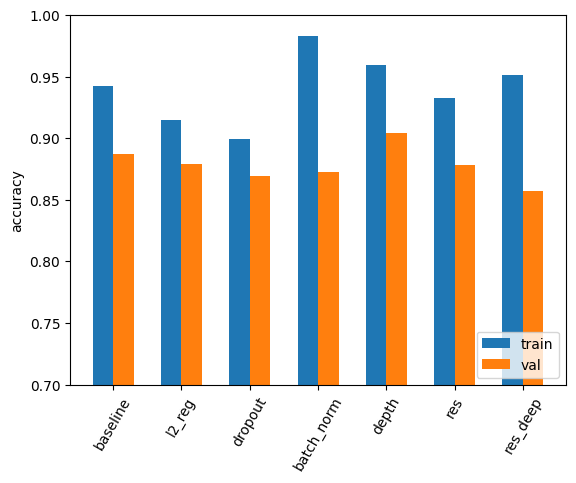

In [90]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width = 0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc)) + width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc)) + width / 2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.show()